# Dataset Analysis



Analyzes the dataset, modifies it and stores this dataset variants:
- `cleaned_set.npz`: outliers removal
- `balanced_mixup_set.npz`: outliers removal + balanced classes via mixup augmentation on minority, and undersampling on majority
- `balanced_oversampled_set.npz`: outliers removal + balanced classes via oversampling on minority, undersampling on majority

## Google Drive - Connecting to the project

In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
project_path = "/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1"
%cd {project_path}
sys.path.append(project_path)

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1CRSDpvo8yN6Wc7UchdjWSs6h8RroV7e4/le acque del friuli - Homework 1


## Imports

In [2]:
%load_ext autoreload
%autoreload 2

import utils

import os
import numpy as np
import cv2

## Data loading

In [3]:
# Parameters for importing the dataset and defining the images size
DATASET_FILE_NAME = "training_set.npz"
INPUT_SHAPE = (96, 96, 3)

In [4]:
# Loading of the dataset
if 'data' in globals():
    print('Dataset already loaded')
else:
    print('Loading Dataset...')
    data = np.load('dataset/' + DATASET_FILE_NAME)
    print('Dataset Loaded')

Loading Dataset...
Dataset Loaded


## Data analysis and preprocessing

In [5]:
# Separation of images and lebels in two separate variables
X = data['images']
y = data['labels']

# Printing of the dimension and shape of the two variables
print(X.shape, y.shape)

(13759, 96, 96, 3) (13759, 1)


Image already saved.


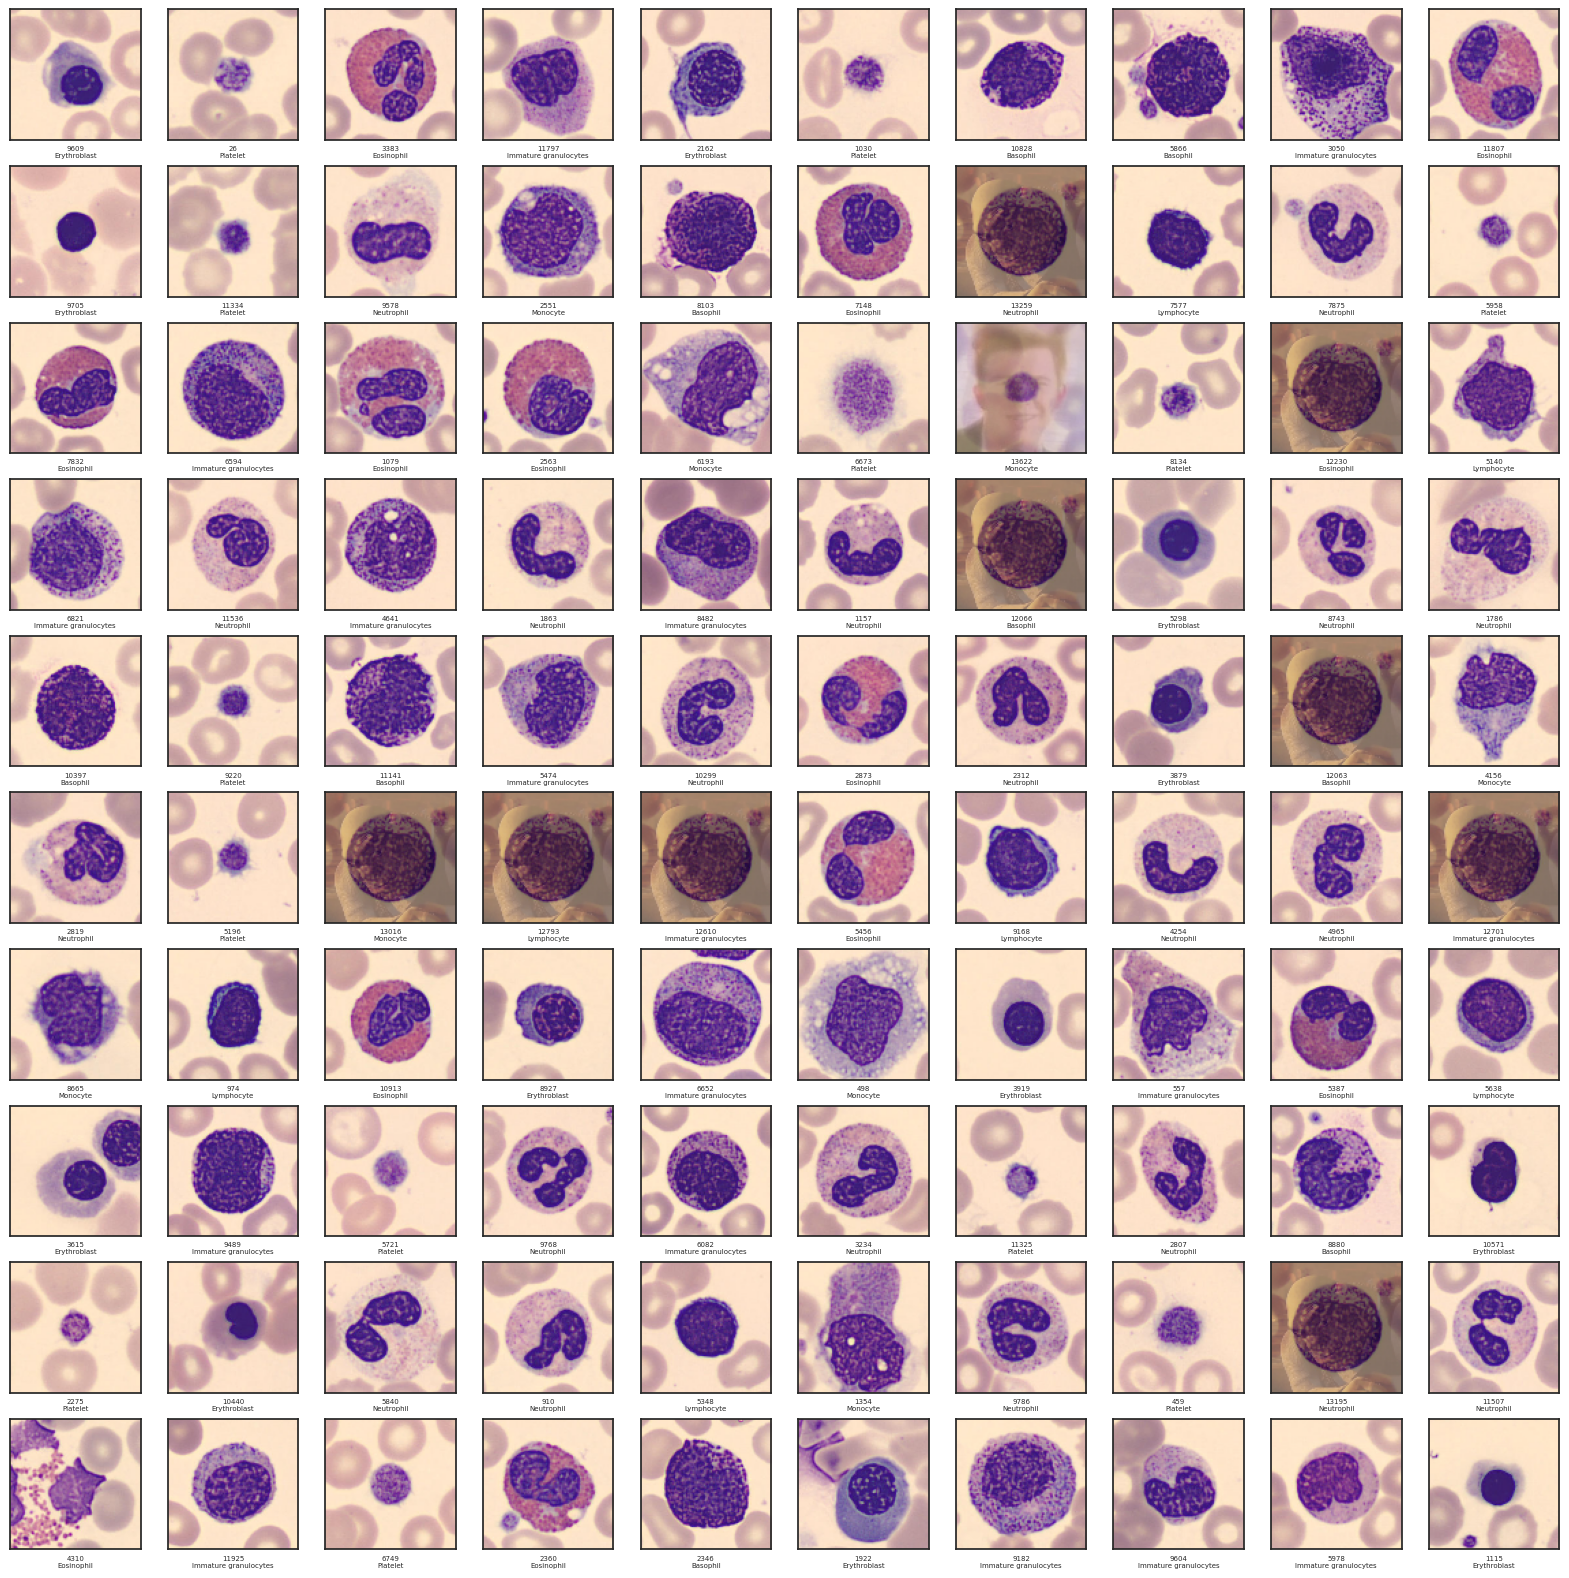

In [6]:
# Partial visualization of the images in the dataset
utils.plot_images(X, y, print_idx=True ,figsize=(20,20), rows=10, columns=10, fontsize=5)
utils.save_fig('original_dataset')

### Outliers identification and removal

Image already saved.


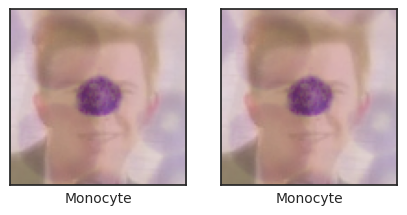

In [10]:
# Identification of the first outlier with modified background
indexes = [13697, 13697]
utils.plot_images(X[indexes], y[indexes], figsize=(5,10), rows=1, columns=2, fontsize=10)
utils.save_fig('outliers')

Image already saved.


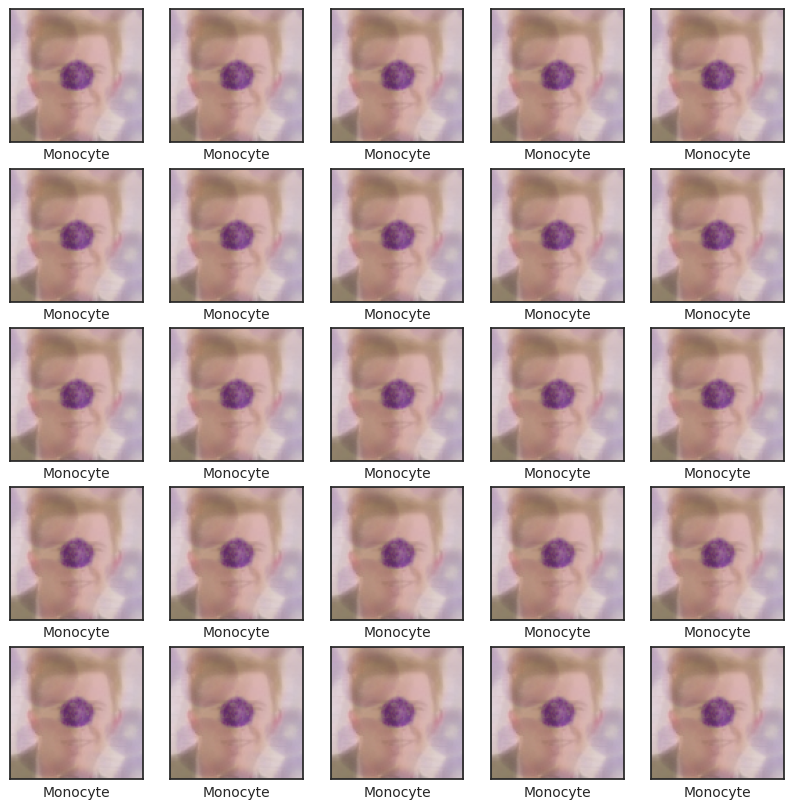

In [8]:
# Finds all Rick Astley and asserts that they are all Monocyte
meme = X[13697]
match_indices = np.where(np.all(X == meme, axis=(1, 2, 3)))[0]
np.random.shuffle(match_indices)

assert np.all(y[match_indices] == y[13697])

utils.plot_images(X[match_indices], y[match_indices],
                  figsize=(10,10), rows=5, columns=5,
                  fontsize=10)
utils.save_fig('cleaned_dataset')

Image already saved.


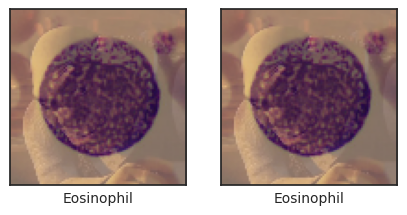

In [9]:
# Identification of the second outlier with modified background
indexes = [12222, 12222]
utils.plot_images(X[indexes], y[indexes], figsize=(5,10), rows=1, columns=2, fontsize=10)
utils.save_fig('outliers')

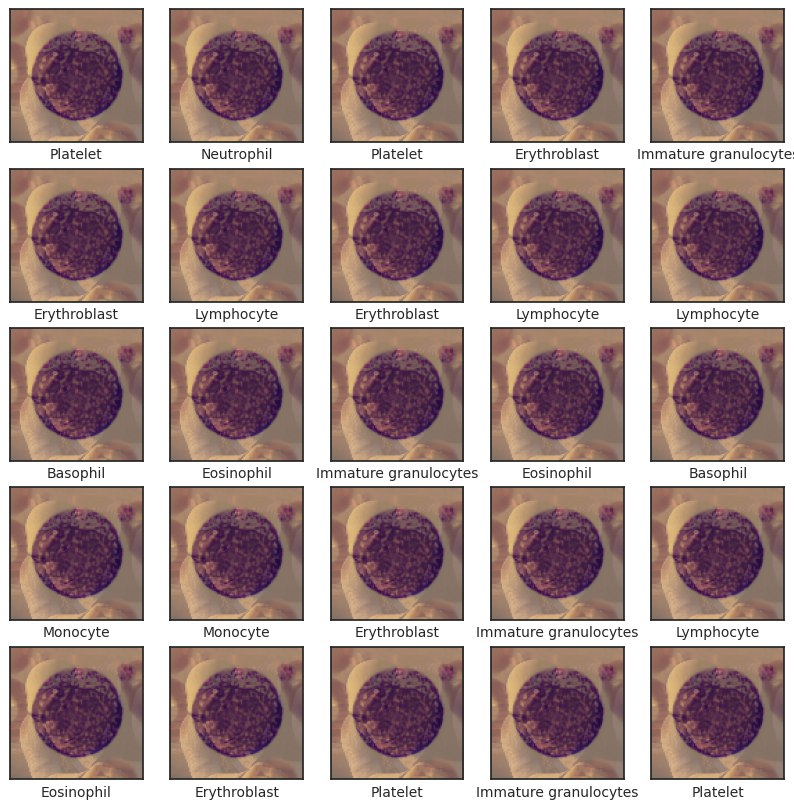

In [11]:
# Finds Sherks and assert that they are not all equal
meme = X[12222]
match_indices = np.where(np.all(X == meme, axis=(1, 2, 3)))[0]
np.random.shuffle(match_indices)

assert np.any(y[match_indices] != y[12222])

utils.plot_images(X[match_indices], y[match_indices],
                  figsize=(10,10), rows=5, columns=5,
                  fontsize=10)

In [12]:
# Function to remove all the memes from the dataset
def remove_meme(X,y):
    memes = [X[13697], X[12222]]
    X_clean = X
    y_clean = y
    for meme in memes:
        match_indices = np.where(np.all(X == meme, axis=(1, 2, 3)))[0]
        X_clean = np.delete(X_clean, match_indices, axis=0)
        y_clean = np.delete(y_clean, match_indices)
    assert X.shape != X_clean.shape
    assert y.shape != y_clean.shape
    assert y_clean.shape[0] == X_clean.shape[0]
    print(X_clean.shape)
    return X_clean,y_clean

In [13]:
# Removing all the memes from the dataset
X_clean, y_clean = remove_meme(X,y)

(11959, 96, 96, 3)


In [ ]:
# Visualizing the cleaned dataset
utils.plot_images(X_clean,y_clean,print_idx=True,figsize=(20,20), rows=10, columns=10, fontsize=5)
utils.save_fig('cleaned_dataset')

Output hidden; open in https://colab.research.google.com to view.

### Checking the distribution of the data

In [ ]:
# Checking the number of elements for each class
unique_values, counts = np.unique(y_clean, return_counts=True)
print('Target labels : ' + str(unique_values))
print('Target counts : ' + str(counts))

Target labels : [0 1 2 3 4 5 6 7]
Target counts : [ 852 2181 1085 2026  849  993 2330 1643]


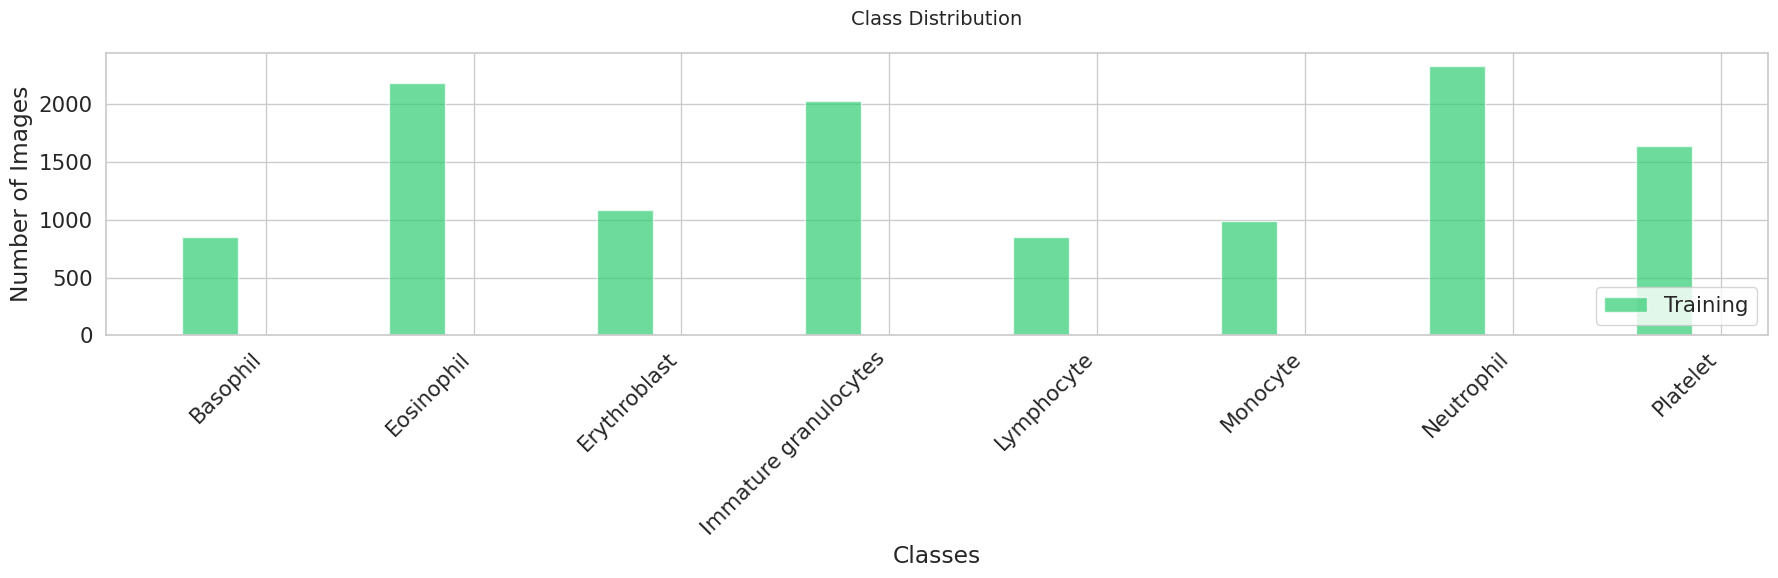

In [ ]:
# Plotting the distribution
utils.plot_class_distribution(y_clean)

Using Augmentation and Class Weighting can be beneficial to the training process

### ⚖ Balancing Classes


Performing class balancing by:
- majority classes:
    - undersampling
- minority classes:
    - mixup augmentation on the same class
    - oversampling


In [ ]:
# Parameters used for balancing the classes
THRESHOLD = 1500 # Number of samples on each class, this defines which classes are considered minority, and which are considered majority
unique_values, counts = np.unique(y_clean, return_counts=True)
minority_class = counts < THRESHOLD

In [ ]:
# Function to perform MixUp augmentation on images
def mixup(img_a,img_b):
    alpha = np.random.uniform(low=0.3, high=0.7)
    return ((1 - alpha) * img_a + alpha * img_b).astype(np.uint8)

# Capping the number of elements in each class under a certain treshold
def split_threshold_classes(X,y):
    X_by_class = [[],[],[],[],[],[],[],[]]
    for i, elem in enumerate(X):
        if len(X_by_class[y[i].item()]) < THRESHOLD:
            X_by_class[y[i].item()].append(elem)
    return X_by_class

#### Balanced by Mixup Augmentation

In [ ]:
# Performing MixUp augmentation and balancing the classes
X_by_class = split_threshold_classes(X_clean,y_clean)
for cell_type in X_by_class:
    while len(cell_type) < THRESHOLD:
        idx_a = np.random.randint(0,len(cell_type))
        idx_b = np.random.randint(0,len(cell_type))
        cell_type.append(mixup(cell_type[idx_a],cell_type[idx_b]))
assert all([len(cell_type) == THRESHOLD for cell_type in X_by_class])
X_balanced_mix = np.concatenate(X_by_class)
y_balanced_mix = np.concatenate([[i]*THRESHOLD for i in range(len(X_by_class))])

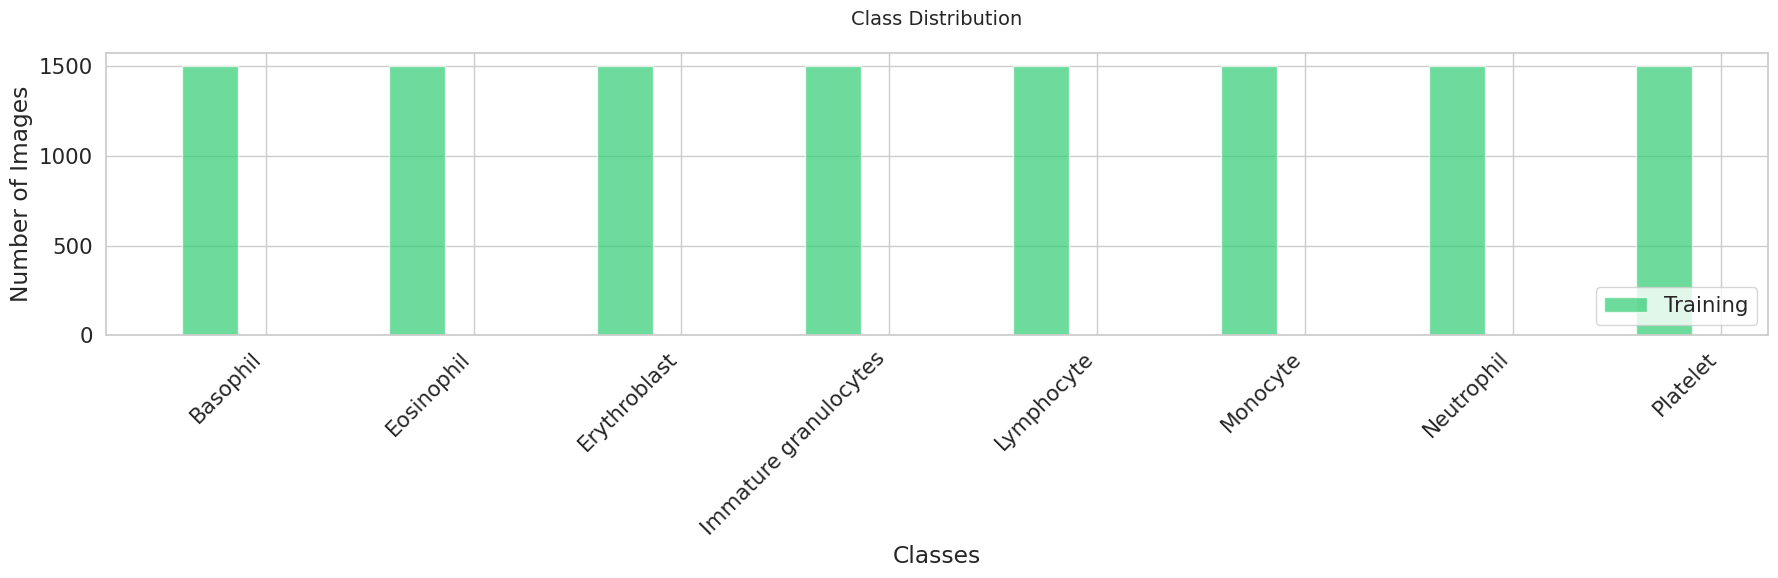

In [ ]:
# Plotting the distribution
utils.plot_class_distribution(y_balanced_mix)

Image already saved.


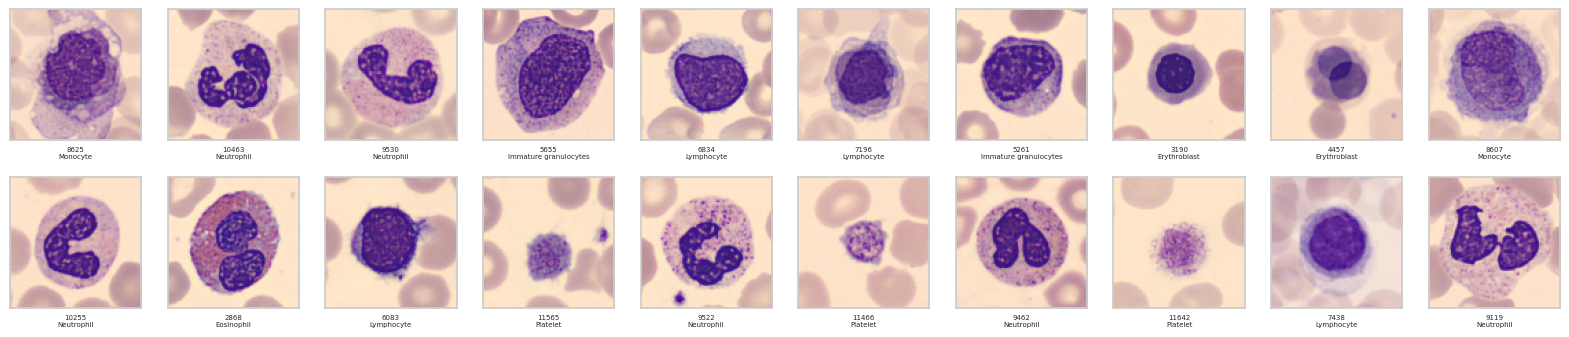

In [ ]:
# Visualizing the dataset after the MixUp augmentation and balancing
utils.plot_images(X_balanced_mix,y_balanced_mix,print_idx=True,figsize=(20,4), rows=2, columns=10, fontsize=5)
utils.save_fig('balanced_dataset_mix')

#### Balanced by Oversampling

In [ ]:
# Performing MixUp augmentation and oversampling the classes
X_by_class = split_threshold_classes(X_clean,y_clean)
for cell_type in X_by_class:
    while len(cell_type) < THRESHOLD:
        idx = np.random.randint(0,len(cell_type))
        cell_type.append(cell_type[idx])
assert all([len(cell_type) == THRESHOLD for cell_type in X_by_class])
X_balanced_ov = np.concatenate(X_by_class)
y_balanced_ov = np.concatenate([[i]*THRESHOLD for i in range(len(X_by_class))])

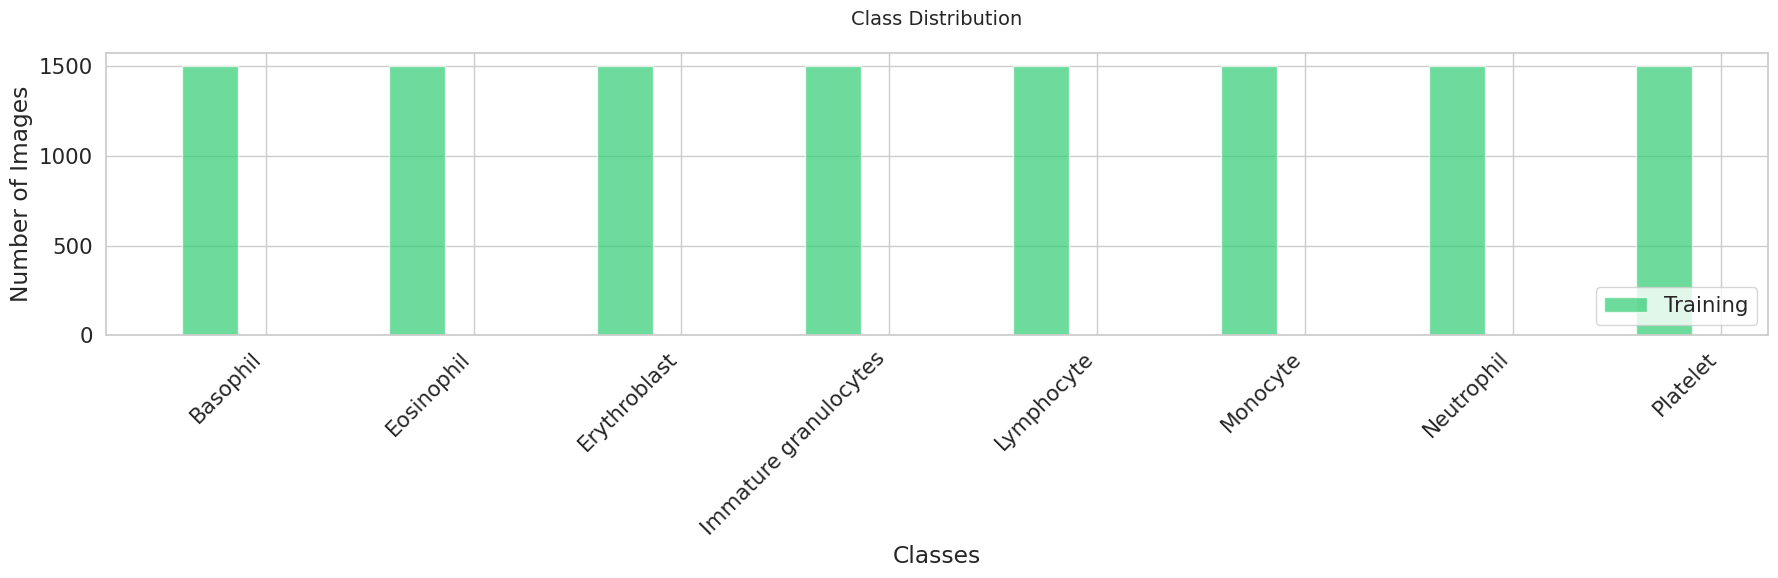

In [ ]:
# Plotting the distribution
utils.plot_class_distribution(y_balanced_ov)

Image already saved.


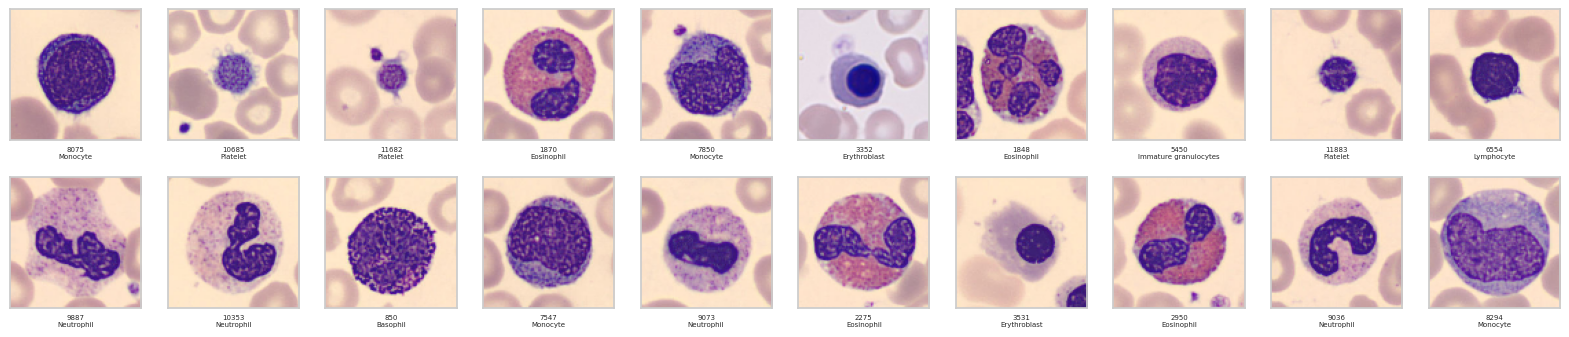

In [ ]:
# Visualizing the dataset after the MixUp augmentation and oversampling
utils.plot_images(X_balanced_ov,y_balanced_ov,print_idx=True,figsize=(20,4), rows=2, columns=10, fontsize=5)
utils.save_fig('balanced_dataset_ov')

### Example of custom augmentation

Image already saved.


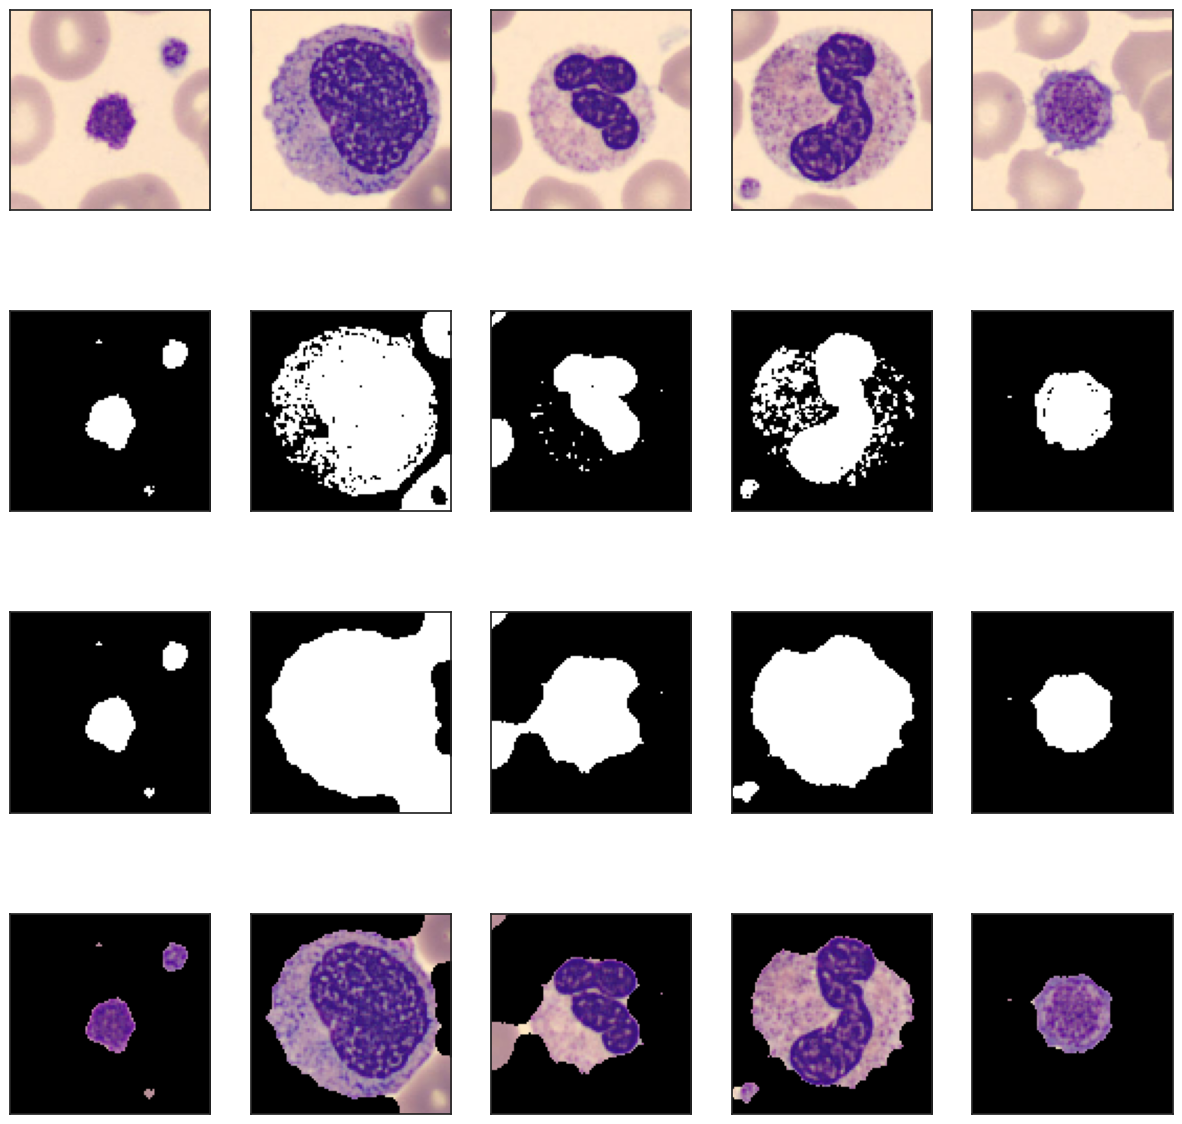

In [ ]:
samples = 5
sample = X[:samples]

def get_mask(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = cv2.threshold(gray, 155, 255, cv2.THRESH_BINARY_INV)[1]
    return mask

def apply_morph(mask):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

def apply_mask(img, mask):
    return cv2.bitwise_and(img,img,mask=mask)

masks = []
masked = []
morph_masks = []
for i in range(len(sample)):
    mask = get_mask(sample[i])
    masks.append(mask)
    morphed = apply_morph(mask)
    morph_masks.append(morphed)
    masked.append(apply_mask(sample[i],morphed))

masks = np.array(masks)
rgb_masks = np.stack((masks,)*3, axis=-1)
morph_masks = np.array(morph_masks)
rgb_morphmasks = np.stack((morph_masks,)*3, axis=-1)
masked = np.array(masked)


concatenated = np.concatenate([sample,rgb_masks], axis=0)
concatenated = np.concatenate([concatenated,rgb_morphmasks], axis=0)
concatenated = np.concatenate([concatenated,masked], axis=0)


utils.plot_images(concatenated, figsize=(15,15), rows=4, columns=samples, fontsize=5, rand=False)

utils.save_fig('augmentation_examples')

## Exporting preprocessed datasets

### Cleaned

In [ ]:
# Creation of the file containing the cleaned dataset
name = 'cleaned_set'
if not os.path.exists(f'dataset/{name}.npz'):
    np.savez(f'dataset/{name}', images=X_clean, labels=y_clean)
    print('New dataset saved')
else :
    print('Dataset already saved')

Dataset already saved


### Balanced by MixUp augmentation

In [ ]:
# Creation of the file containing the balanced dataset with MixUp augmentation
name = 'balanced_mixup_set'
if not os.path.exists(f'dataset/{name}.npz'):
    np.savez(f'dataset/{name}', images=X_balanced_mix, labels=y_balanced_mix)
    print('New dataset saved')
else :
    print('Dataset already saved')

Dataset already saved


### Balanced by oversampling

In [ ]:
# Creation of the file containing the oversampled dataset
name = 'balanced_oversampled_set'
if not os.path.exists(f'dataset/{name}.npz'):
    np.savez(f'dataset/{name}', images=X_balanced_ov, labels=y_balanced_ov)
    print('New dataset saved')
else :
    print('Dataset already saved')

Dataset already saved
